# Decode neural dynamics

In this tutorial, we decode neural activities during the mouse learning and performaing a motor task of joystick pulling.

In [1]:
from autosort_neuron import *
import warnings
warnings.filterwarnings("ignore")

/n/holystore01/LABS/jialiu_lab/Users/yichunhe/AutoSort/autosort_neuron/sorting.py:19: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


We first load the AutoSort sorting results.

In [2]:
save_pth = './AutoSort_data/'
day_pth = './processed_data/'
results_data_path =  f'./AutoSort_data/model_save/train_day0310_0/offline_result/0319/'
extremum_channels_ids_pth='./processed_data/Ephys_concat_0310_0315/mountainsort/extremum_channels_ids.csv'

(sorting,  
 trial_start, 
 trial_end,  
 cont_trigger_all_all,
 recording_cmr) = read_AutoSort_data('0319',
                                     day_pth,
                                     results_data_path, 
                                     save_pth=save_pth,
                                     extremum_channels_ids_pth=extremum_channels_ids_pth
                                     )  

0319 there are 28 trials at an interval of: 19383


We extract the spikes 1ms before and 2ms after the onset of mouse pulling.

In [3]:


num_trials = len(trial_start)

start_time_point=0
end_time_point = cont_trigger_all_all.shape[0]

onlinetraj_raster = np.zeros((end_time_point-start_time_point,len(sorting.unit_ids)))
for ind,i in tqdm(enumerate(sorting.unit_ids )):
    try:
        add_unit = list(sorting.get_unit_spike_train(i))
    except KeyError:
        continue
    onlinetraj_raster[add_unit,ind]=1

0it [00:00, ?it/s]

20it [00:00, 92.98it/s]


In [4]:
onlinetraj_raster.shape

(9908480, 20)

In [5]:
start_interval1 = 10000
start_interval2 = 20000
num_stimulus = start_interval1+start_interval2
num_neurons=onlinetraj_raster.shape[1]
num_bins = 50

idx1 = trial_start>start_interval1
trial_start=trial_start[idx1]
trial_end=trial_end[idx1]

idx2 = trial_end<end_time_point-start_interval2
trial_start=trial_start[idx2]
trial_end=trial_end[idx2]

In [6]:
num_trials = len(trial_start)
trial_test=np.zeros((num_trials, num_neurons, num_stimulus))#len(trial_start)
time_bin = num_bins
data=np.zeros((time_bin*(num_trials),onlinetraj_raster.shape[1]))
data_datahigh=np.zeros((num_trials, num_neurons, int((start_interval1+start_interval2)/10) ))
trial_num=[]
for j in np.arange(len(trial_end)):
    trial_test[j,...] = onlinetraj_raster[trial_start[j]-start_interval1:trial_start[j]+start_interval2,:].T
    arr_reduced = block_reduce(trial_test[j], block_size=(1,int(trial_test[j].shape[1]/time_bin)),
                                func=np.sum, cval=0)
    data[(j)*time_bin:(j+1)*time_bin,:] = arr_reduced.T
    arr_reduced_2 = block_reduce(trial_test[j], block_size=(1,10),
                                func=np.max, cval=0)        
    data_datahigh[j,:,:] = arr_reduced_2
    trial_num+=[j]*num_bins

In [7]:
stimulus_times = [-1, 2]

In [8]:
def plot_neuron_spike_train(stimulus_times,start_interval1, start_interval2):
    fig, axs = plt.subplots(nrows=4, ncols=int(ceil(num_neurons/4)), figsize=(10, 10), sharey='row')
    for ax, neuron_idx in zip(axs.flat,
                     range(num_neurons)):
        neuron_data = trial_test[:, neuron_idx, :]
        bin_edges = np.linspace(stimulus_times[0], stimulus_times[-1], num_bins+1)

        for i in range(num_trials):
            ind = np.where(neuron_data[i,:])[0]
            ax.eventplot(ind,lineoffsets=i,linewidths=0.5, colors='black')
            ax.set_ylabel('Trial')
            ax.set_ylim(-0.5, num_trials + 0.5)
            ax.set_title(f'Neuron {neuron_idx+1}')
            ax.set_xticks([0,start_interval1,start_interval1+15000,start_interval1+start_interval2],
                          [stimulus_times[0], 0,(start_interval1+15000)/10000-1, stimulus_times[-1]])
    plt.subplots_adjust(hspace=0.5)
    # plt.savefig('figures/'+date_id_all+'neuron_spiketrain.png',dpi=300)

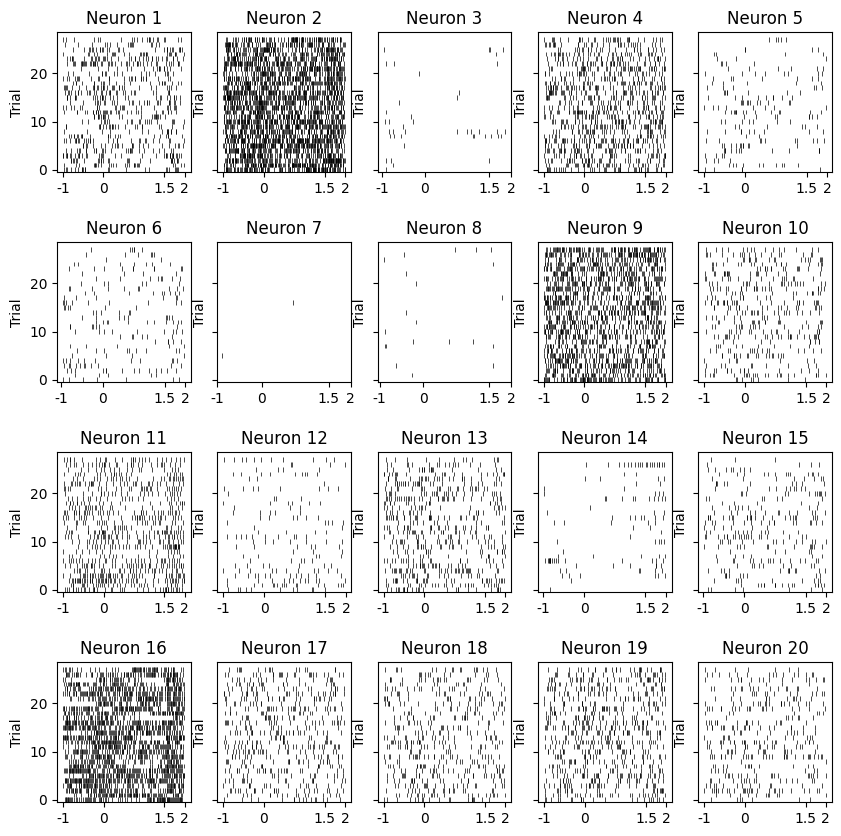

In [9]:
plot_neuron_spike_train(stimulus_times,start_interval1, start_interval2)    


Similarity matching algorithm

In [ ]:
data_sma = SMA(data,time_bin)